# Composite systems and interface with QuTIP

B. McDonough

For further documentation of scqubits see https://scqubits.readthedocs.io/en/latest/.

Systems of interests for quantum computing generally mutual coupling between different quantum systems. By driving these individual sybsystems, we can perform single- or multi-qubit gates.

In the context of superconducting circuits, a common method of driving the circuit is to to capacitively couple a vialtage bias to one or multiple nodes of the circuit. By a proper choice of drive frequency , amplitude and envelope, logical operations can be achieved.

The popular python package QuTiP can be used to simulate the time dynamics of quantum systems. For the simulation of superconducting circuits,scQubits provides an easy and transparent interface to QuTiP through the `HilbertSpace` class. A tutorial on the usage of the HilbertSpace class can be found [here](https://github.com/scqubits/scqubits-examples/blob/master/examples/demo_hilbertspace.ipynb). 

## Composite Systems in scQubits
A system consisting of several coupled subsystems can be represented using a Hamiltonian of the form

$$ 
H = \sum_{i}H_0^{(i)} + \sum_{ij}H_1^{(ij)}
$$

where $i,j$ both index over the subsystems. Here, $H_0^{(i)}$ is the "bare" Hamiltonian of the $i^\text{th}$ subsystem, only acting nontrivially on this subsystem. 

$H_1^{(ij)}$ is the Hamiltonian modeling the coupling of subsystem $i$ to subsystem $j$, and similarly only acts nontrivially on these two subsystems. Capacitive coupling between a qubit and a resonator, which is one standard method of coupling qubits, results in a coupling Hamiltonian of the form $H_1^{(ij)} = g_{ij}\hat n_i (a_j + a^{\dagger}_j)$, where $\hat n_i$ is the charge operator for the $i^\text{th}$ qubit and $a_j, a_j^\dagger$ are the annihilation and creation operators respectively for the $j^\text{th}$ resonator. In the following we will consider the dispersive regime, where $g$ is relatively small compared to the frequency difference $\Delta_{ij}$ between the oscillator and the qubit.

scQubits models such a system by first diagonalizing each $H_0^{(i)}$ and expressing each subsystem operator in the diagonal basis. Tensor products of these eigenstates $| \mu_{\vec i}\rangle = |\mu_{i_1}\rangle_1 \otimes |\mu_{i_2}\rangle_2 \otimes ... \otimes |\mu_{i_n}\rangle_n$, known as the "bare" eigenstates, are used to write the Hamiltonian $H' =  \sum_{i}H_0^{(i)} + \sum_{ij}H_1^{(ij)}$ as a matrix by computing 
$$\langle \mu_{\vec k} |\sum_{i}H_{0} + \sum_{ij}+ H^{(ij)} | \mu_{\vec l} \rangle
 = \sum_i E_{0}^{(i)}+ \sum_{ij}\langle \mu_{\vec k} |H^{(ij)} | \mu_{\vec l} \rangle
 $$
 for each $i,j,k,l$. Lastly, these matrix elements are used to diagonalize $H'$, obtaining the "dressed" eigenstates of the coupled system and the corresponding energy levels.

## Driving Operators
The effect of a time-dependent voltage introduced at one or more of the nodes of the circuit can be taken into account through the addition of a term to the Hamiltonian:
$$
H' = H + \sum_i H_d^{(i)}
$$
The term $H_d^{(i)}$ only acts nontrivially on the $i^\text{th}$ subsystem, and takes the form $H_d = \varepsilon_i(t)\hat n_i$, where $\hat n_i$ is the charge number operator for the $i^\text{th}$ subsystem.

## Example: Fluxonium coupled to a resonator

The Hamiltonian of a fluxonium qubit can be written as
$$
H_0 ^{(f)} = 4E_C \hat n_f^2 - E_J \cos(\hat\phi_f-\varphi_{ext})+\frac{1}{2}E_L\hat\phi_f^2 \ .
$$
The Hamiltonian of a resonator is 
$$
H_0^{(r)} = E_{osc}a^\dagger a \ ,
$$
where the units are chosen so that $\hbar = 1$, and constant term is customarily dropped. The Hamiltonian modeling these two subsystems and their interaction is
$$
H' = H_{0}^{(f)} + H_{0}^{(r)} + g\hat n_r(a+a^\dagger)
$$
scQubits is able to represent such a coupled system and diagonalize it for an appropriate choice of $g$. The process for doing so is shown below:

## Set up Hilbert space

Following the procedure described in the scQubits tutorial, we can represent this Hamiltonian $H'$ using a `HilbertSpace` object. This class is the main way to symbolically represent coupled systems in scQubits, and it also is one of the main points of exposure between the scQubits API and QuTiP.

In [47]:
import scqubits as scq
import numpy as np
import qutip as qt

In [5]:
import scqubits as scq

qbt = scq.Fluxonium(
    EJ = 8.9,
    EC = 2.5,
    EL = 0.5,
    flux = 0.33,
    cutoff = 110,
    truncated_dim = 9,
    id_str = 'fluxonium'
)

osc = scq.Oscillator(
    E_osc=4.0,
    truncated_dim=5,
    id_str = 'resonator'
)

hilbertspace = scq.HilbertSpace([qbt, osc])

hilbertspace.add_interaction(
    g_strength = 0.2,
    op1 = qbt.n_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

# Drive operators
The drive Hamiltonians $H_d^{(i)}$, as discussed, are proportional to the charge number operators $\hat n_i$. These operators are generally off-diagonal with respect to the dressed eigenbasis. In order to simulate the evolution of the system with qutip, these operators first need to be expressed in this basis.

The representation of $\hat n_i$ in the bare energy eigenbasis of the $i^\text{th}$ subsystem can be safely truncated to a level specified by a cutoff parameter in the constructor of the object, since the anharmonicity of the qubit will allow high-lying energy levels to be safely neglected. This offers a speedup for computing the matrix elements in the dressed eigenbasis, which accounts for the contribution of the coupling terms to the energy eigenstates.

In [6]:
#populate the dictionaries with the choice of eigenstates
hilbertspace.generate_lookup()

In [7]:
#convert an operator from the bare eigenbasis to the dressed eigenbasis
def bare_to_dressed(operator, hilbertspace):
    evecs, = hilbertspace["evecs"]
    return operator.transform(evecs)

#get the bare productstate by subsystem
def lookup_productstate(*states):
    states_by_index = sorted([(hilbertspace.get_subsys_index(sys), state) for (sys, state) in states])
    return hilbertspace.bare_productstate([state for _,state in states_by_index])

def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    """This method can be used to express a subsystem operator in the dressed energy eigenbasis
    of the full hilbertspace, expecially useful for simulations in QuTiP.

    Args:
        operator (Qobj): A subsystem operator with dimension cutoff x cutoff
        subsystem (Qubit or Resonator): The subsystem acted on by the operator
        hilbertspace (HilbertSpace): The Hilbert space representing the composite system

    Returns:
        (Qobj): An operator with the same dimension as the HilbertSpace
    """

    #Get bare eigenvectors of subsystem stored in hilbertspace
    hilbertspace.bare_eigenstates(subsystem) #TODO: figure out why this needs to be run twice to work
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    #Express operator in bare eigenbasis and tensor with appropriate identities
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    #Get full dressed eigenbasis
    evecs, = hilbertspace["evecs"]
    if dressed_eigenbasis:
        evecs, = hilbertspace["evecs"]
        return bare_to_dressed(op_id_wrap, hilbertspace)
    else:
        #Transform wrapped operator into dressed eiegenbasis
        return op_id_wrap

### Compute charge operators
This method can now be used to express both charge operators acting on the full system in the dressed energy eigenbasis:

In [8]:
#resonator charge operator
phi_r = basis_change(osc.annihilation_operator()+osc.creation_operator(), osc, hilbertspace)
#qubit charge operator
n_qbt = basis_change(qbt.n_operator(), qbt, hilbertspace)

## Driving Simulation in QuTIP
Now that the operators are obtained in the new energy eigenbasis, qutip's `sesolve` or `mesolve` functionality can be used to simulate the time dynamics associated with driving the system. In the case of the Fluxonium, the $\hat n$ operator acts like a $\sigma_x$ operator on the first two energy eigenstates, transitioning between them. We may drive transitions between these two states by choosing the drive frequency $\omega_d$ to be the resonant frequency of the qubit.

The drive can either be applied to the qubit directly or to the resonator. Since the frequency of the resonator is detuned from the frequency of the qubit, the qubit may be driven directly without creating photons in the resonator, and virtual excitations can be created in the resonator to drive the qubit.

In [51]:
import numpy as np
import qutip as qt

Omega = 2*np.pi*.01 #Drive strength in GHz
#0-1 transition frequency of the qubit
wd, = hilbertspace.energy_by_bare_index((1,0)) - hilbertspace.energy_by_bare_index((0,0))

#time-dependent drive e(t)
def drive_coeff(t, args):
    omega_d = args['omega_d']
    return Omega*np.cos(wd*t)

#Hamiltonian is the interaction Hamiltonian plus the drive Hamiltonian 
evals, = hilbertspace["evals"]
diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*hilbertspace.subsystem_count)
H_qbt_drive = [diag_dressed_hamiltonian,[n_qbt, drive_coeff]]

In [54]:
state = lookup_productstate((qbt, 0), (osc,0))
tlist = np.linspace(0, 1000, 1000)
result = qt.sesolve(H_qbt_drive, state, tlist, e_ops = [state*state.dag()], args = {"omega_d": wd})

Text(0, 0.5, '|0>')

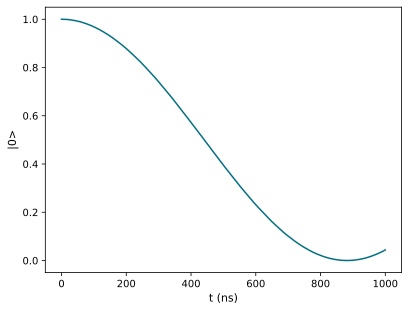

In [55]:
plt.plot(tlist, result.expect[0])
plt.xlabel("t (ns)")
plt.ylabel("|0>")

### Driving through the resonator

In [57]:
Omega = 2*np.pi*.01 #Drive strength in GHz
#0-1 transition frequency of the qubit
wd, = hilbertspace.energy_by_bare_index((1,0)) - hilbertspace.energy_by_bare_index((0,0))

#time-dependent drive
def drive_coeff(t, args):
    omega_d = args['omega_d']
    return Omega*np.cos(wd*t)

#Hamiltonian is the interaction Hamiltonian plus the drive Hamiltonian 
H_osc_drive = [bare_to_dressed(hilbertspace.hamiltonian(), hilbertspace),[phi_r, drive_coeff]]

In [58]:
state = lookup_productstate((qbt, 0), (osc,0))
tlist = np.linspace(0, 5000, 5000)
result = qt.sesolve(H_osc_drive, state, tlist, e_ops = [state*state.dag()], args = {"omega_d": wd})

Text(0, 0.5, '|0>')

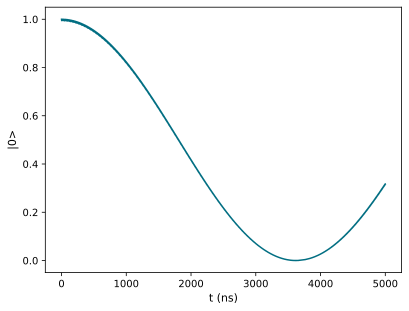

In [59]:
from matplotlib import pyplot as plt
plt.plot(tlist, result.expect[0])
plt.xlabel("t (ns)")
plt.ylabel("|0>")